# Visualization of CO2-spectra for different temperatures

In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as pltc

%matplotlib inline
import matplotlib as mplt
from matplotlib import gridspec

# plotting
import chart_studio.plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import seaborn as sb

import pandas as pd
import scipy
import peakutils
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy import signal
from scipy import constants as con
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from mymisc import *
from glob import glob

In [2]:
# get spectral data, for specific molcule specie (different folders)
lab = [
    "pureCO2",
    "100H2O_10CO2",
    "100CO_4CO2",
    "100CO_26CO2",
    "100CO_70CO2",
]  # in respect to pontoppidan2008 [CO2 :H2O_14 :100; CO2 :CO = 4 :100; CO2 :CO = 26 :100; CO2 :CO = 70 :100; CO2 :CO = 112 :100; Pure CO2

# select your temperature range
Tlim = [0.0, 190.0]

# define wavelength and flux for all temperatures
temp = []
lam = []
lam15 = []  # index closest to 15um
flu = []

for l in lab:  # extension towards different input specy
    tempt = []
    lamt = []
    flut = []
    # call the referring txt-file
    path = glob("../lab_data/" + l + "/*", recursive=True)  # generally find all temperatures
    for t in path:
        with open(t) as f:
            lines = f.read().split("\n")

        lam0 = []
        flu0 = []
        for i in lines:
            dat = i.split(" ")
            try:
                lam0.append(
                    1 / float(dat[0]) * 1e4
                )  # convert to float and from wave number to wavelength
            except:  # last line is empty
                continue
            try:
                flu0.append(float(dat[1]))
            except:
                flu0.append(0)
        t_sel = (t.split(l + "/")[1]).split(".0K.txt")[0]
        if (
            Tlim[0] <= float(t_sel) <= Tlim[1]
        ):  # selection of temperatures (predefinable)
            tempt.append(t_sel)
            lamt.append(lam0)
            flut.append(flu0)
    lam.append(lamt)
    lam15.append(
        np.abs(np.array(lam0) - 15).argmin()
    )  # find index which is closest to 15um band
    flu.append(flut)
    temp.append(tempt)

In [3]:
lam15[0], lam15[1], len(lam15), len(temp), temp

(603,
 545,
 5,
 5,
 [['50', '80', '10'],
  ['170',
   '140',
   '60',
   '50',
   '160',
   '130',
   '90',
   '30',
   '180',
   '150',
   '70',
   '80',
   '10',
   '120',
   '110',
   '40',
   '185',
   '100'],
  ['30', '10'],
  ['30', '10'],
  ['10']])

### Plotting the spectra

In [4]:
# conversion wave number to wave length and back :)
# for second axis
def wlen(x):
    return x


def wnum(x):
    # x = (1/y*1e4)
    y = (1e4) / x
    return y

/tmp/ipykernel_865326/3263931867.py:17: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.

/tmp/ipykernel_865326/3263931867.py:70: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword

/tmp/ipykernel_865326/3263931867.py:70: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword

/home/tneumann/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword



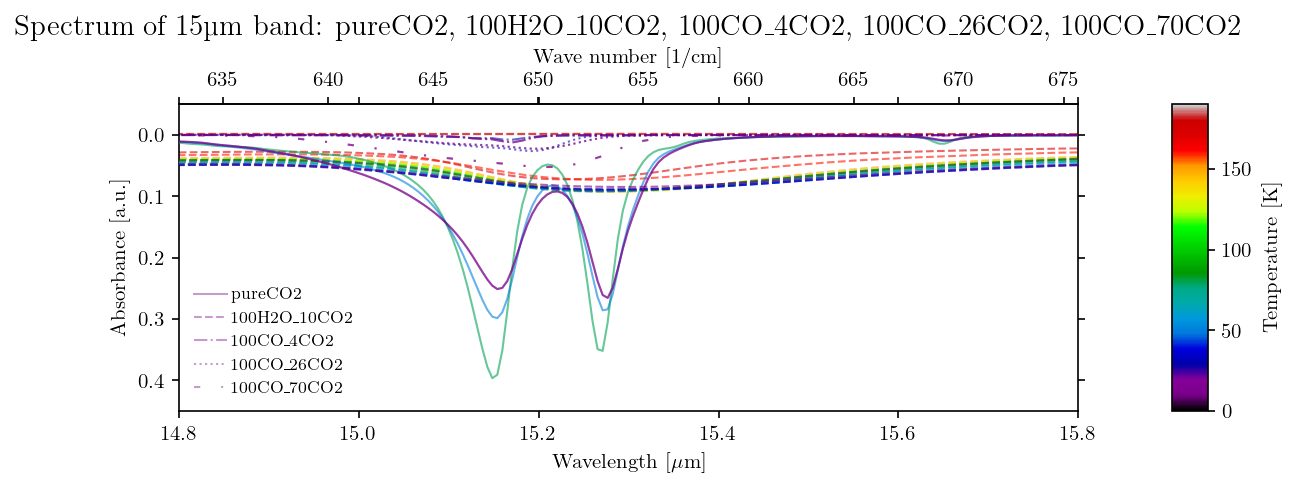

In [5]:
# adjust plotting properties
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.04])

pagewidth, columnwidth = set_plot_defaults()
fig = plt.figure(figsize=(columnwidth * 2.5, columnwidth * 3 / 4))
ax = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

# ranges for CO2 band: Pontoppidan 2205
lmin, lmax = [14.8, 15.8]
fmin, fmax = [0.45, -0.05]

# different line styles
line = ["-", "--", "-.", ":", (0, (3, 10, 1, 10))]

# colorbar implementation for displaying the temperature of the measurements
fig.subplots_adjust(right=0.5)
cmap = mplt.cm.nipy_spectral  # _rainbow
norm = mplt.colors.Normalize(vmin=Tlim[0], vmax=Tlim[1])
cb1 = mplt.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation="vertical")
cb1.set_label("Temperature [K]")

for l in range(len(lab)):
    #tind = temp[l].index(min(temp[l]))
    for t in range(len(temp[l])):
        # plot different spectra for all the selected lab data species in their different temperatures
        ax.plot(
            lam[l][t],
            flu[l][t],
            color=cmap(norm(int(temp[l][t]))),
            zorder=(100 - int(temp[l][t])),
            linestyle=line[l],
            alpha=0.6,
        )
    # plot last temperature seperate to add label !once!
    ax.plot(
        lam[l][t],
        flu[l][t],
        color=cmap(norm(np.min([eval(i) for i in temp[l]]))),
        linestyle=line[l],
        alpha=0.4,
        label=str(lab[l]),
        zorder=100,
    )


ax.set_ylabel(r"Absorbance [a.u.]")
ax.set_xlabel(r"Wavelength [$\mu$m]")
ax2 = ax.secondary_xaxis(
    "top", functions=(wnum, wlen))  # secondary axis is derived by the conversion of the primary axis
ax2.set_xlabel(r"Wave number [1/cm]")

ax.set_xlim(lmin, lmax)
ax.set_ylim(fmin, fmax)
ax.set_title(
    r"Spectrum of 15µm band: "
    + lab[0]
    + ", "
    + lab[1]
    + ", "
    + lab[2]
    + ", "
    + lab[3]
    + ", "
    + lab[4],
    size=14,
)
ax.legend(loc="best", prop={"size": 8})

plt.savefig(
    "./figures/spectrum_co2_15micron_minmaxK_5species.pdf",bbox_inches='tight', dpi="figure", format="pdf")

### find peaks and mark them

/tmp/ipykernel_865326/3314697622.py:17: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.

/tmp/ipykernel_865326/3314697622.py:94: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword



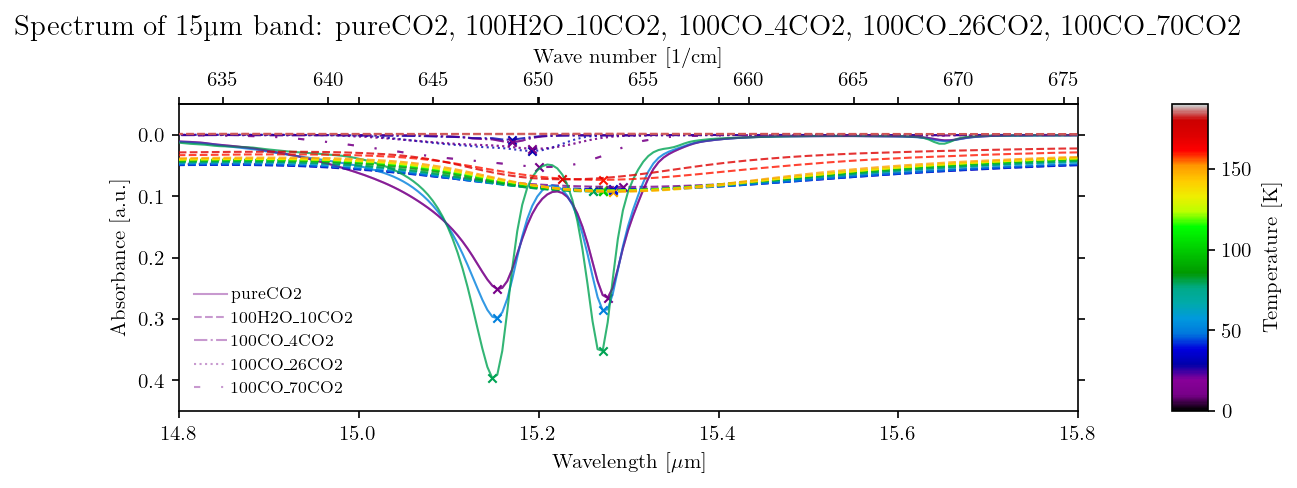

In [6]:
# new plot
# adjust plotting properties
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.04])
pagewidth, columnwidth = set_plot_defaults()
fig = plt.figure(figsize=(columnwidth * 2.5, columnwidth * 3 / 4))
ax = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

# calculate peaks in spectrum
# options to find all peaks: height = [0.005,100], distance=10, width = [5,100]
xpeak = []
ypeak = []
caxis = []


# colorbar implementation
fig.subplots_adjust(right=0.5)
cmap = mplt.cm.nipy_spectral  # _rainbow
norm = mplt.colors.Normalize(vmin=Tlim[0], vmax=Tlim[1])
cb1 = mplt.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation="vertical")

cb1.set_label("Temperature [K]")
# select part of spectrum
ax.set_xlim(lmin, lmax)
ax.set_ylim(fmin, fmax)

for l in range(len(lab)):
    # for keeping the [lab[temperature]]-structure
    xp = []
    yp = []
    cp = []
    for t in range(len(temp[l])):
        hig = np.abs(np.array(lam[l][t]) - lmin).argmin()
        low = np.abs(np.array(lam[l][t]) - lmax).argmin()
        em = flu[l][t][low:hig]  # select wavelength range [lmin,lmax]
        indices, _ = find_peaks(em, height=[0.005, 100], distance=10, width=[5, 100])  # guess properties for most effective peak fitting
        if len(indices) > 2:
            indices = (indices[::-1][:2])[::-1] # just use first 2 peaks instead of 3 /more
        xlam = [
            lam[l][t][low + j] for j in indices
        ]  # correction for selection effect of peaks in given range
        xp.append(xlam[::-1]) #invert array (ascending)
        yflu = [flu[l][t][low + j] for j in indices]
        yp.append(yflu[::-1]) #invert array (ascending)
        ccol = [int(temp[l][t])] * len(xlam)
        cp.append(cmap(norm(int(temp[l][t]))))
        # plot spectra in dependence on  their temperature
        ax.plot(
            lam[l][t],
            flu[l][t],
            color=cmap(norm(int(temp[l][t]))),
            linestyle=line[l],
            zorder=(int(temp[l][t])),
            alpha=0.8,
        )
        # plot peaks on top of curves
        ax.scatter(xlam, yflu, marker="x", color=cmap(norm(int(temp[l][t]))))

    ax.plot(
        lam[l][t],
        flu[l][t],
        color=cmap(norm(np.min([eval(i) for i in temp[l]]))),
        linestyle=line[l],
        alpha=0.4,
        label=str(lab[l]),
        zorder=100,
    )
    # for outer lab structure
    xpeak.append(xp)
    ypeak.append(yp)
    caxis.append(cp)

# layout
ax.set_ylabel(r"Absorbance [a.u.]")
ax.set_xlabel(r"Wavelength [$\mu$m]")
ax2 = ax.secondary_xaxis("top", functions=(wnum, wlen))
ax2.set_xlabel(r"Wave number [1/cm]")

ax.set_title(
    r"Spectrum of 15µm band: "
    + lab[0]
    + ", "
    + lab[1]
    + ", "
    + lab[2]
    + ", "
    + lab[3]
    + ", "
    + lab[4],
    size=14,
)
ax.legend(loc="best", prop={"size": 8})

plt.savefig(
    "./figures/spectrum_co2_15micron_peaks_5species_1T.pdf", bbox_inches='tight', dpi='figure', format="pdf"
)  # , res = 300)

In [7]:
### peak fitting referring to Will's code

from scipy.integrate import trapz, simps
from scipy.special import erf
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
##############################################
def get_line_number2(value, matrix):
    for i, line in enumerate(matrix, 1):
        if line == value:
            return i


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
##################   GAUSSIAN FUCNTIONS #######################################
def asym_peak(t, pars):
    a0 = pars[0]  # height
    a1 = pars[1]  # center
    a2 = pars[2]  # width of gaussian
    f = a0*np.exp(-(t - a1)**2/(2*a2**2))
    return f


def one_peak(t, *pars):    
    'function of two overlapping peaks'
    a10 = pars[0]  
    a11 = pars[1]  
    a12 = pars[2]  
    p1 = asym_peak(t, [a10, a11, a12])
    return p1


def two_peaks(t, *pars):    
    'function of two overlapping peaks'
    a10 = pars[0]  
    a11 = pars[1]  
    a12 = pars[2]  
    a20 = pars[3]  
    a21 = pars[4]  
    a22 = pars[5]  
    p1 = asym_peak(t, [a10, a11, a12])
    p2 = asym_peak(t, [a20, a21, a22])
    return p1 + p2

def three_peaks(t, *pars):    
    'function of three overlapping peaks'
    a10 = pars[0]  
    a11 = pars[1]  
    a12 = pars[2]  
    a20 = pars[3]  
    a21 = pars[4]  
    a22 = pars[5]
    a30 = pars[6]
    a31 = pars[7]
    a32 = pars[8]  
    p1 = asym_peak(t, [a10, a11, a12])
    p2 = asym_peak(t, [a20, a21, a22])
    p3 = asym_peak(t, [a30, a31, a32])
    return p1 + p2 + p3

def four_peaks(t, *pars):    
    'function of two overlapping peaks'
    a10 = pars[0]  
    a11 = pars[1]  
    a12 = pars[2]  
    a20 = pars[3]  
    a21 = pars[4]  
    a22 = pars[5]
    a30 = pars[6]
    a31 = pars[7]
    a32 = pars[8]
    a40 = pars[9]
    a41 = pars[10]
    a42 = pars[11]  
    p1 = asym_peak(t, [a10, a11, a12])
    p2 = asym_peak(t, [a20, a21, a22])
    p3 = asym_peak(t, [a30, a31, a32])
    p4 = asym_peak(t, [a40, a41, a42])
    return p1 + p2 + p3 + p4

In [8]:
#limits for fitting data
lmin = 14.55
lmax = 16.6
pfit = [14.8,16.3] #points to fit
exp = 3  # degree of polynomial fit
lim = 10  # trange of fitted data points
def poly_fit(x, deg):
    y = 0
    for i in range(len(deg)):
        y += deg[i] * pow(x, (len(deg) - i - 1))
    return y

splines.roots =  [15.09827945 15.18521049 15.24531513 15.30044227]
splines.roots =  [15.11184558 15.17237171 15.24919116 15.28658621]
splines.roots =  [15.09557492 15.19712644 15.24241669 15.30547835]
splines.roots =  [15.1031393  15.42106397]
splines.roots =  [15.13513916 15.52271289]
splines.roots =  [15.10159316 15.56121762]
splines.roots =  [15.09991771 15.57364284]
splines.roots =  [15.11664281 15.51642544]
splines.roots =  [15.12942601 15.52788052]
splines.roots =  [15.09612181 15.56482426]
splines.roots =  [15.09766184 15.58453555]
splines.roots =  [15.13667188 15.50733169]
splines.roots =  [15.10487234 15.54879596]
splines.roots =  [15.10712208 15.54293318]
splines.roots =  [15.0932561  15.58836455]
splines.roots =  [15.12567008 15.53020361]
splines.roots =  [15.12070916 15.53288028]
splines.roots =  [15.09932496 15.58249818]
splines.roots =  [15.11716481 15.53601337]
splines.roots =  [15.0988134  15.19860644]
splines.roots =  [15.12811226 15.19466389]
splines.roots =  [15.0850

/home/tneumann/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning:

Covariance of the parameters could not be estimated

/tmp/ipykernel_865326/2016796223.py:154: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.

/tmp/ipykernel_865326/2016796223.py:173: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword



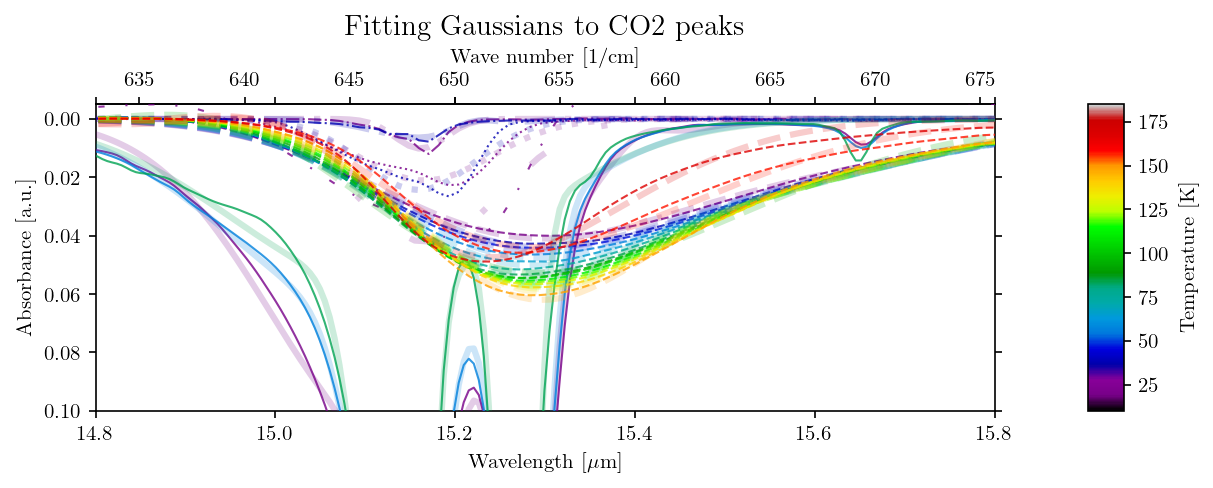

In [9]:
#save all fitting data 
'''
Structure file
>lab species
    >temperature
        >data: lam, pop0, pop1 (*no of Gaussians), fwhm
'''

fwhm = [] #needed

#plot adjust plotting properties
gs = gridspec.GridSpec(1,2,width_ratios=[1,0.04])
pagewidth, columnwidth = set_plot_defaults()
fig = plt.figure(figsize=(columnwidth*2.5, columnwidth*3/4))
ax  = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

for l in range(len(lab)):
    #dat_file.write(struct.pack('i'*len(lab[l]), *lab[l]))
    fwhml = [] #to keep structure
    for t in range(len(temp[l])):
        fwhmt = []
        if xpeak[l][t] != []:
            peaks = []
            
            hig = np.abs(np.array(lam[l][t]) - lmin).argmin() #define fitting range, according to peak finding range
            low = np.abs(np.array(lam[l][t]) - lmax).argmin()
            # define flux/ wavelength range -inverted because of the wavelength
            t0s = np.array(lam[l][t])[low:hig][::-1] # WAVELENGTH #invert array
            intensity = np.array(flu[l][t])[low:hig][::-1] # FLUX/OPTICAL DEPTH #invert array

            xmin = np.abs(np.array(t0s)-pfit[0]).argmin()
            xmax = np.abs(np.array(t0s)-pfit[1]).argmin()

            ran1 = (np.linspace(xmin-lim,xmin+lim, 2*lim+1)).astype(int) #simplify?
            ran2 = (np.linspace(xmax-lim,xmax+lim, 2*lim+1)).astype(int)
            ran = np.hstack((ran1,ran2))
            
            if lab[l].find('_') != -1:#l.find(':'): #only continuum fitting for CO2 mixtures
                fit = np.polyfit(t0s[ran],intensity[ran],exp)
                intensity0s = intensity - poly_fit(t0s,fit)
            else:
                intensity0s = intensity
            #plot data in range
            ax.plot(t0s,intensity0s, color=caxis[l][t],linestyle = line[l],zorder = (int(temp[l][t])) , alpha = 0.8)#label = 'data'
            
            #to improve ENIIGMA fitting, substract continuum + redfine these values
            lam[l][t] = t0s[::-1] # WAVELENGTH #invert array
            flu[l][t] = intensity0s[::-1] 
            # fit as many Gaussian peaks as possible from 4 --> 1
            guess = (0.05, xpeak[l][t][0], 0.2) # (e.g., height, center, width of gaussian)
            guess2 = guess + (0.01, xpeak[l][t][0] - 0.2, 0.2)

            try:
            #gaussians = one_peak(st, *pars), two_peaks(t, *pars), three_peaks(t, *pars), four_peaks(t, *pars)
                guess3 = guess2 + (0.05, xpeak[l][t][1], 0.2) #calculated later, in case of just one peak
                guess4 = guess3 + (0.01, xpeak[l][t][1]+0.2, 0.2)
                popt0s, pcov0s = curve_fit(four_peaks, t0s, intensity0s, guess4)
                #ax.plot(t0s, four_peaks(t0s, *guess4),'g-', label = 'initial guess: 4 peaks')
                ax.plot(t0s, four_peaks(t0s, *popt0s), color=caxis[l][t],linestyle = line[l], zorder = (int(temp[l][t])),  linewidth=3., alpha = 0.2, label = 'final fit: 4 peaks')

                pars10s = popt0s[0:3]
                pars20s = popt0s[3:6]
                pars30s = popt0s[6:9]
                pars40s = popt0s[9:12]

                peak10s = asym_peak(t0s, pars10s)
                peak20s = asym_peak(t0s, pars20s)
                peak30s = asym_peak(t0s, pars30s)
                peak40s = asym_peak(t0s, pars40s)

                peakts = peak10s + peak20s + peak30s + peak40s
                peaks.append(peakts)
            except:
                try:
                    #gaussians = one_peak(st, *pars), two_peaks(t, *pars), three_peaks(t, *pars), four_peaks(t, *pars)
                    guess3 = guess2 + (0.05, xpeak[l][t][1], 0.2) #calculated later, in case of just one peak
                    popt0s, pcov0s = curve_fit(three_peaks, t0s, intensity0s, guess3)
                    #ax.plot(t0s, three_peaks(t0s, *guess3),'g-', label = 'initial guess: 3 peaks')
                    ax.plot(t0s, three_peaks(t0s, *popt0s), color=caxis[l][t],linestyle = line[l], zorder = (int(temp[l][t])),  linewidth=3., alpha = 0.2, label = 'final fit: 3 peaks')

                    pars10s = popt0s[0:3]
                    pars20s = popt0s[3:6]
                    pars30s = popt0s[6:9]

                    peak10s = asym_peak(t0s, pars10s)
                    peak20s = asym_peak(t0s, pars20s)
                    peak30s = asym_peak(t0s, pars30s)

                    #ax.plot(t0s, peak10s, 'y-', label = 'Gaussian1')
                    #ax.plot(t0s, peak20s, 'y-', linestyle='--', label = 'Gaussian2')
                    #ax.plot(t0s, peak30s, 'y-', linestyle=':', label = 'Gaussian3')

                    peakts = peak10s + peak20s + peak30s
                    peaks.append(peakts)

                except:
                    try:
                        popt0s, pcov0s = curve_fit(two_peaks, t0s, intensity0s, guess2)
                        #ax.plot(t0s, two_peaks(t0s, *guess2),'g-', label = 'initial guess: 2 peaks')
                        ax.plot(t0s, two_peaks(t0s, *popt0s), color=caxis[l][t],linestyle = line[l], zorder = (int(temp[l][t])),  linewidth=3., alpha = 0.2, label = 'final fit: 2 peaks')

                        pars10s = popt0s[0:3]
                        pars20s = popt0s[3:6]

                        peak10s = asym_peak(t0s, pars10s)
                        peak20s = asym_peak(t0s, pars20s)

                        #ax.plot(t0s, peak10s, 'y-', label = 'Gaussian1')
                        #ax.plot(t0s, peak20s, 'y-', linestyle='--', label = 'Gaussian2')

                        peakts = peak10s + peak20s
                        peaks.append(peakts)
                    except:
                        popt0s, pcov0s = curve_fit(one_peak, t0s, intensity0s, guess)
                        #ax.plot(t0s, one_peak(t0s, *guess),'g-', label = 'initial guess: 1 peak')
                        ax.plot(t0s, one_peak(t0s, *popt0s), color=caxis[l][t],linestyle = line[l], zorder = (int(temp[l][t])),  linewidth=3., alpha = 0.2, label = 'final fit: 1 peak')


                        pars10s = popt0s[0:3]

                        peak10s = asym_peak(t0s, pars10s)

                        #ax.plot(t0s, peak10s, 'y-', label = 'Gaussian1')

                        peakts = peak10s
                        peaks.append(peakts)


            splines = UnivariateSpline(t0s, peaks-np.max(peaks)/2, s=0)
            print('splines.roots = ', splines.roots())
            try:
                r1s, r2s, r3s, r4s = splines.roots()
                fwhms = r2s-r1s, r4s-r3s #required to reproduce the plot
                fwhmt += fwhms #fwhm's for each temperature

                #ax.axvspan(r1s, r2s, facecolor='yellow', alpha=0.5, label= 'fitting range 1')
                #ax.axvspan(r3s, r4s, facecolor='yellow', alpha=0.5, label= 'fitting range 2')
            except:
                try:
                    r1s, r2s = splines.roots()
                    fwhms = [r2s-r1s] #required to reproduce the following plot
                    fwhmt += fwhms

                    #ax.axvspan(r1s, r2s, facecolor='yellow', alpha=0.5, label= 'fitting range')
                except:
                    print('no root of peak')
                    
        fwhml.append(fwhmt)
    fwhm.append(fwhml)

#####testing with lab1: 3 spectra with 2-3 lines
#colorbar implementation
fig.subplots_adjust(right=0.5)
cmap = mplt.cm.nipy_spectral #_rainbow
norm = mplt.colors.Normalize(vmin=np.min([eval(i) for i in temp[1]]), vmax=np.max([eval(i) for i in temp[1]]))#float(np.max(temp[0])))
cb1 = mplt.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

cb1.set_label('Temperature [K]')
ax.set_xlim(14.8,15.8)
ax.set_ylim(0.1,-0.005)

ax.set_ylabel(r'Absorbance [a.u.]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax2 = ax.secondary_xaxis('top', functions=(wnum, wlen))
ax2.set_xlabel(r'Wave number [1/cm]')
#ax.legend(loc = 'best', prop={'size': 8})
        
ax.set_title(r'Fitting Gaussians to CO2 peaks', size = 14)

plt.savefig('./figures/peak_fitting_co2_15micron_general_gaussian_fitting_zoom.pdf',bbox_inches='tight', dpi='figure', format='pdf')#, res = 300)

### discuss goodness of fit, insuifficient?! :/

/tmp/ipykernel_865326/1341402680.py:17: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.

/tmp/ipykernel_865326/1341402680.py:43: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword



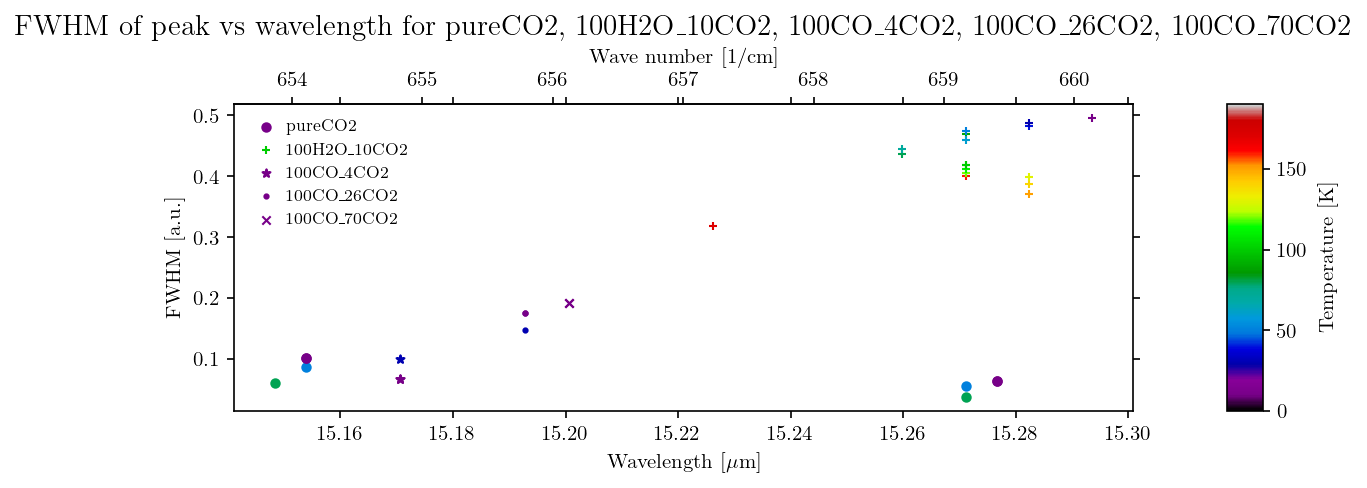

In [10]:
# reproduce FWHM-lambda plot
'''
here add FHWM of primary Gaussian
'''
#adjust plotting properties
pagewidth, columnwidth = set_plot_defaults()
fig = plt.figure(figsize=(columnwidth*2.5, columnwidth*3/4))
ax  = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

gs = gridspec.GridSpec(1,2,width_ratios=[1,0.04])

#define different marker
dot = ['o','+','*','.','x']

#colorbar implementation for displaying the temperature of the measurements
fig.subplots_adjust(right=0.5)
cmap = mplt.cm.nipy_spectral #_rainbow
norm = mplt.colors.Normalize(vmin=Tlim[0], vmax=Tlim[1])
cb1 = mplt.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Temperature [K]')

for l in range(len(lab)):
    for t in range(len(temp[l])):
        # plot different spectra for all the selected lab data species in their different temperatures
        try:
            ax.scatter(xpeak[l][t], fwhm[l][t], marker = dot[l], color=caxis[l][t],zorder = (100-int(temp[l][t])))#,label = str(lab[l]))
        except:
            continue
    #plot last temperature seperate to add label !once!
    ax.scatter(xpeak[l][t], fwhm[l][t], marker = dot[l], color=caxis[l][t], zorder = (100-int(temp[l][t])),label = str(lab[l]))
    
ax.set_ylabel(r'FWHM [a.u.]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax2 = ax.secondary_xaxis('top', functions=(wnum, wlen)) #secondary axis is derived by the conversion of the primary axis
ax2.set_xlabel(r'Wave number [1/cm]')

ax.set_title(r'FWHM of peak vs wavelength for '+ lab[0]+ ', ' + lab[1]+ ', ' + lab[2] + ', ' + lab[3] + ', ' + lab[4],size = 14)
ax.legend(loc = 'best', prop={'size': 8})

plt.savefig('./figures/spectrum_co2_fwhd_diagramm.pdf',bbox_inches='tight',dpi = 'figure', format='pdf')

/tmp/ipykernel_865326/537814408.py:14: UserWarning:

This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.

/tmp/ipykernel_865326/537814408.py:66: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword



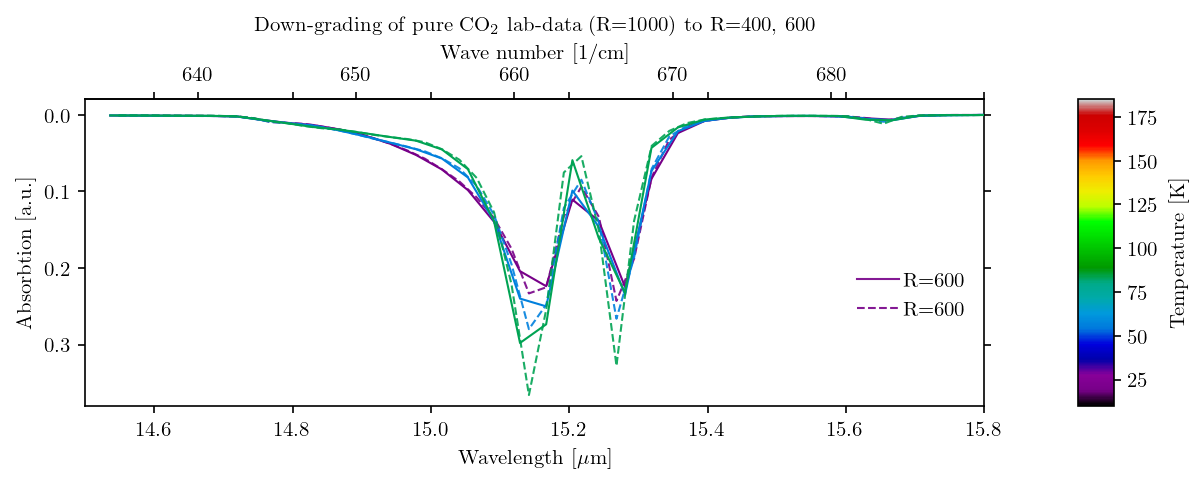

In [26]:
# down-grading of lab spectrum
import coronagraph as cg
# Construct new low-res wavelength grid
#wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, dlam = dl)
# Down-bin flux to low-res
#flr = cg.downbin_spec(spi3[0], spi3[1], wl, dlam=dwl)
gs = gridspec.GridSpec(1,2,width_ratios=[1,0.04])
pagewidth, columnwidth = set_plot_defaults()
fig = plt.figure(figsize=(columnwidth*2.5, columnwidth*3/4))
ax  = fig.add_subplot(gs[0])
cax = fig.add_subplot(gs[1])

#colorbar implementation
fig.subplots_adjust(right=0.5)
cmap = mplt.cm.nipy_spectral #_rainbow
norm = mplt.colors.Normalize(vmin=np.min([eval(i) for i in temp[1]]), vmax=np.max([eval(i) for i in temp[1]]))#float(np.max(temp[0])))

# Set the wavelength and resolution parameters
lammin = 14.5
lammax = 16.3
R = np.array([400,600]) #100, 150, 200, 400, 600, 1000])

bottom_val = np.zeros(len(R))

# save lab data files extra
#for second spitzer data
                  
# Loop over R
for i, r in enumerate(R):
    # Construct new low-res wavelength grid
    wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, r)

    for l in range(len(lab)):
        for t in range(len(temp[l])):

            # Down-bin flux to low-res
            Alr = cg.downbin_spec(flu[l][t][::-1],lam[l][t][::-1], wl, dlam=dwl)

            # Plot
            if l==0:
                ax.plot(wl, Alr, color=caxis[l][t],linestyle = line[l+i],zorder = (int(temp[l][t])),alpha=1-i/10)#, label = 'R='+str(r))#+' @'+temp[l][t]+' K')
            #write data as .dat in ice folder
            lab_dgrade = open('./ICES_TNeumann/'+str(lab[l])+'_'+str(temp[l][t])+'_r'+str(r)+'.dat', "a")
            for z in range(len(wl)):
                lab_dgrade.write(str(1 / wl[z] * 1e4)+'\t'+str(Alr[z])+'\n')
            lab_dgrade.close()

ax.plot(0,0, color=caxis[l][t],linestyle = line[0],zorder = (int(temp[l][t])),alpha=1-i/10, label = 'R='+str(r))
ax.plot(0,0, color=caxis[l][t],linestyle = line[0+i],zorder = (int(temp[l][t])),alpha=1-i/10, label = 'R='+str(r))

ax.set_xlim(14.5,15.8)
ax.set_ylim(0.38, -0.02)
cb1 = mplt.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')

cb1.set_label('Temperature [K]')
ax.legend(bbox_to_anchor=(1, 0.5))
ax.set_ylabel(r'Absorbtion [a.u.]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_title(r'Down-grading of pure CO$_2$ lab-data (R=1000) to R=400, 600')

ax = ax.secondary_xaxis('top', functions=(wnum, wlen)) #secondary axis is derived by the conversion of the primary axis
ax.set_xlabel(r'Wave number [1/cm]')
#fig.legend()
plt.savefig('./figures/down_grading_lab_spectra.pdf',bbox_inches='tight', format='pdf')